In [1]:
import shapefile
import zipfile
import shapely
import pyproj
import pandas as pd
from shapely.geometry import shape
import osmnx as ox
import geopandas as gpd
from numpy.linalg import norm
import numpy as np
import math
from matplotlib import pyplot as plt
import contextily as cx
from pyproj.crs import CRS

import route2vel.utils as utils

In [2]:
%load_ext autoreload
%autoreload 2
%load_ext memory_profiler

In [3]:
path = "../../resources/shapefiles/nord-est-latest-free.shp.zip"
crs = CRS("""GEOGCS["GCS_WGS_1984",DATUM["D_WGS_1984",SPHEROID["WGS_1984",6378137,298.257223563]],PRIMEM["Greenwich",0],UNIT["Degree",0.017453292519943295]]""")
# crs = 'epsg:4326'
# Description of CRS: http://download.geofabrik.de/osm-data-in-gis-formats-free.pdf

In [4]:
with zipfile.ZipFile(path, 'r') as shapezip:
    shapefiles = []
    for zipinfo in shapezip.infolist():
        if zipinfo.filename.endswith('shp'): #5 files for each name, check one of them
            shapefiles.append(zipinfo.filename.replace('.shp', ''))
    print(path)
    print('├─ ' + '\n├─ '.join(shapefiles[:-1]) + f'\n└─ {shapefiles[-1]}')

../../resources/shapefiles/nord-est-latest-free.shp.zip
├─ gis_osm_buildings_a_free_1
├─ gis_osm_landuse_a_free_1
├─ gis_osm_natural_a_free_1
├─ gis_osm_natural_free_1
├─ gis_osm_places_a_free_1
├─ gis_osm_places_free_1
├─ gis_osm_pofw_a_free_1
├─ gis_osm_pofw_free_1
├─ gis_osm_pois_a_free_1
├─ gis_osm_pois_free_1
├─ gis_osm_railways_free_1
├─ gis_osm_roads_free_1
├─ gis_osm_traffic_a_free_1
├─ gis_osm_traffic_free_1
├─ gis_osm_transport_a_free_1
├─ gis_osm_transport_free_1
├─ gis_osm_water_a_free_1
└─ gis_osm_waterways_free_1


In [249]:
# zoomin
# gdf: gdf or list of gdf,kwargs (for plot)
def display_bounded_shapes(gdf: gpd.GeoDataFrame|list[(gpd.GeoDataFrame,dict)], boundsTl, boundsBr, latLong=False, scale=1) -> gpd.GeoDataFrame:
    if latLong:
        boundsTl = boundsTl[::-1]
        boundsBr = boundsBr[::-1]
    shape = shapely.Polygon([boundsTl, (boundsBr[0], boundsTl[1]), boundsBr, (boundsTl[0], boundsBr[1])])
    shape = shapely.affinity.scale(shape, xfact=scale, yfact=scale)
    shape_prep = shapely.prepared.prep(shape)

    if type(gdf) != list:
        gdf = [(gdf, {})]

    fig, ax = plt.subplots(figsize=(10,10))
    cropped_gdfs = []
    for (gdf_i, args) in gdf:
        gdf_cropped = gdf_i.loc[gdf_i.geometry.apply(lambda p: shape_prep.contains(p))]
        gdf_cropped.plot(ax=ax, **args)
        cropped_gdfs.append(gdf_cropped)
    gpd.GeoSeries(shape, crs=crs).plot(ax=ax, facecolor='none', edgecolor='r')
    # graph_gdf_nodes.loc[graph_gdf_nodes.geometry.apply(lambda p: shape2_prep.contains(p))].plot(ax=ax, color='r')
    cx.add_basemap(ax=ax, crs=crs, source=cx.providers.OpenStreetMap.Mapnik)
    plt.show()

    return cropped_gdfs

def count_unmatched_values(df_A, df_B, column_name=None):
    # Perform an inner join between df_A and df_B on the specified column
    merged = df_A.join(
        df_B, on=column_name, how='inner',
        lsuffix='_og', rsuffix='_shp',
    ) if column_name else df_A.join(
        df_B, how='inner',
        lsuffix='_og', rsuffix='_shp',
    )

    # Count the number of rows in df_A that have missing values after the join
    unmatched_count = len(df_A) - len(merged)

    # print(len(df_A), len(df_A[column_name]),  len(df_B[column_name]), len(merged))
    
    return unmatched_count

def coord_distance_meters(coords1:tuple, coords2:tuple, lon_first=True):
    """Convert coord distance to meters. Make sure to use WGS-84 coordinates.
    """
    if lon_first:
        coords1 = coords1[::-1]
        coords2 = coords2[::-1]

    return ox.distance.great_circle_vec(*coords1, *coords2)

def coord_shape_length_meters(line: shapely.LineString, lon_first=None):
    return sum([coord_distance_meters(cur, next, lon_first) for cur, next in zip(line.coords[:-1], line.coords[1:])])

In [6]:
sf = shapefile.Reader(f'{path}/gis_osm_roads_free_1')

In [7]:
shapefile.SHAPETYPE_LOOKUP[sf.shapeType]

'POLYLINE'

In [8]:
print(f"Number of features: {len(sf)}")

Number of features: 1329351


In [9]:
print("Bounding box:")
sf.bbox

Bounding box:


[9.1576612, 43.7235897, 13.9408461, 47.1049458]

In [10]:
shapes = sf.shapes()
print(f"Number of shapes: {len(shapes)}")
print("Sample shape:")
shapes[1]

Number of shapes: 1329351
Sample shape:


Shape #1: POLYLINE

In [11]:
shapes[1].bbox

[11.0360924, 45.9019839, 11.036331, 45.9036982]

In [12]:
shapes[1].points

[(11.0361912, 45.9019839),
 (11.0361196, 45.9020474),
 (11.0360924, 45.9021091),
 (11.0361104, 45.9022037),
 (11.0362429, 45.9024444),
 (11.0363139, 45.9027501),
 (11.036331, 45.903433),
 (11.0363168, 45.9036982)]

In [13]:
shapes[1].__geo_interface__

{'type': 'LineString',
 'coordinates': [(11.0361912, 45.9019839),
  (11.0361196, 45.9020474),
  (11.0360924, 45.9021091),
  (11.0361104, 45.9022037),
  (11.0362429, 45.9024444),
  (11.0363139, 45.9027501),
  (11.036331, 45.903433),
  (11.0363168, 45.9036982)]}

In [14]:
sf.fields

[('DeletionFlag', 'C', 1, 0),
 ['osm_id', 'C', 12, 0],
 ['code', 'N', 4, 0],
 ['fclass', 'C', 28, 0],
 ['name', 'C', 100, 0],
 ['ref', 'C', 20, 0],
 ['oneway', 'C', 1, 0],
 ['maxspeed', 'N', 3, 0],
 ['layer', 'N', 12, 0],
 ['bridge', 'C', 1, 0],
 ['tunnel', 'C', 1, 0]]

In [15]:
fieldnames = [f[0] for f in sf.fields[1:]]
fieldnames

['osm_id',
 'code',
 'fclass',
 'name',
 'ref',
 'oneway',
 'maxspeed',
 'layer',
 'bridge',
 'tunnel']

In [16]:
df0 = pd.DataFrame(sf.records(), columns=fieldnames)

In [17]:
df0 = df0.applymap(lambda x: None if x == '' else x).applymap(lambda x: True if x == 'T' else False if x == 'F' else x)
df0['maxspeed'] = df0['maxspeed'].apply(lambda x: None if x == 0 else x)
df0

,osm_id,code,fclass,name,ref,oneway,maxspeed,layer,bridge,tunnel
0,2132466,5111,motorway,Brennerautobahn - Autostrada del Brennero,A22,False,110.0,0,False,False
1,2132483,5115,tertiary,None,SS12,False,NaN,0,False,False
2,2132486,5112,trunk,Via Berlino,None,B,50.0,0,False,False
3,2132503,5114,secondary,Via Divisione Julia,SP359R,B,50.0,0,False,False
4,2132510,5132,trunk_link,None,None,False,50.0,0,False,False
...,...,...,...,...,...,...,...,...,...,...
1329346,1176653833,5141,service,None,None,B,NaN,0,False,False
1329347,1176653834,5154,path,None,None,B,NaN,0,False,False
1329348,1176659360,5141,service,None,None,B,NaN,0,False,False
1329349,1176659361,5153,footway,None,None,B,NaN,0,False,False


In [18]:
print("Present values")
pd.DataFrame({
    'total': {col: len(df0[df0[col].notnull()]) for col in df0.columns},
    'pct': {col: round(len(df0[df0[col].notnull()]) / len(df0) * 100, 1) for col in df0.columns},
})
    

Present values


,total,pct
osm_id,1329351,100.0
code,1329351,100.0
fclass,1329351,100.0
name,518440,39.0
ref,95872,7.2
oneway,1329351,100.0
maxspeed,95511,7.2
layer,1329351,100.0
bridge,1329351,100.0
tunnel,1329351,100.0


In [19]:
print("Value counts")
# pd.DataFrame({
#     'total': {col: len(df0[df0[col].notnull()]) for col in df0.columns},
#     'pct': {col: round(len(df0[df0[col].notnull()]) / len(df0) * 100, 1) for col in df0.columns},
# })
pd.concat([
    pd.DataFrame([len(df0)], index=["total"], columns=["uniq vals"]),
    pd.DataFrame(df0.nunique(), columns=["uniq vals"]),
])

Value counts


,uniq vals
total,1329351
osm_id,1329351
code,28
fclass,28
name,103181
ref,2045
oneway,3
maxspeed,20
layer,11
bridge,2


In [20]:
df1 = df0.assign(geometry=[shape(g) for g in sf.shapes().__geo_interface__['geometries']])
df1

,osm_id,code,fclass,name,ref,oneway,maxspeed,layer,bridge,tunnel,geometry
0,2132466,5111,motorway,Brennerautobahn - Autostrada del Brennero,A22,False,110.0,0,False,False,"LINESTRING (11.3591755 46.491375, 11.359701 46..."
1,2132483,5115,tertiary,None,SS12,False,NaN,0,False,False,"LINESTRING (11.0361912 45.9019839, 11.0361196 ..."
2,2132486,5112,trunk,Via Berlino,None,B,50.0,0,False,False,"LINESTRING (11.1114354 46.0769033, 11.1113951 ..."
3,2132503,5114,secondary,Via Divisione Julia,SP359R,B,50.0,0,False,False,"LINESTRING (9.6309729 44.5040044, 9.6316857 44..."
4,2132510,5132,trunk_link,None,None,False,50.0,0,False,False,"LINESTRING (11.1125541 46.0748465, 11.1126492 ..."
...,...,...,...,...,...,...,...,...,...,...,...
1329346,1176653833,5141,service,None,None,B,NaN,0,False,False,"LINESTRING (12.0224132 44.2075462, 12.0223412 ..."
1329347,1176653834,5154,path,None,None,B,NaN,0,False,False,"LINESTRING (12.0221537 44.208142, 12.0223127 4..."
1329348,1176659360,5141,service,None,None,B,NaN,0,False,False,"LINESTRING (12.0198233 44.2042927, 12.0197177 ..."
1329349,1176659361,5153,footway,None,None,B,NaN,0,False,False,"LINESTRING (12.0213835 44.2072158, 12.0215243 ..."


In [21]:
print(f"% of available values: {100 * len(df1['geometry'].dropna()) / len(df1):.2f}%")

% of available values: 100.00%


As expected, shapefile is dedicated to geometry. Now to check if the SF is missing files from the .osm.ovp file.

In [22]:
gdf1 = gpd.GeoDataFrame(df1, crs=crs)

In [23]:
gdf1.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- lon[east]: Longitude (Degree)
- lat[north]: Latitude (Degree)
Area of Use:
- undefined
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

<Axes: >

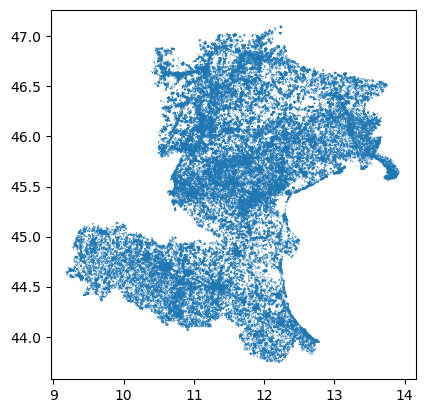

In [24]:
gdf1[::15].plot()

In [25]:
sf.close()

In [26]:
gdf2 = gdf1.rename(columns={'osm_id': 'osmid'}).astype({'osmid': int}).set_index('osmid')

Compare with previous data

In [27]:
# graph = ox.graph_from_place('Bologna', simplify=False)
# ox.save_graphml(graph, '../../assets/graph/Bologna_RAW.graphml')
graph = ox.load_graphml('../../resources/graph/Bologna_RAW.graphml')

Filter SHP data to area of previous data for meaningful comparision

,0
geometry,"POLYGON ((11.2296206 44.5304918, 11.2296933 44..."
bbox_north,44.556094
bbox_south,44.42103
bbox_east,11.433608
bbox_west,11.229621
place_id,307687213
osm_type,relation
osm_id,43172
lat,44.49382
lon,11.342633


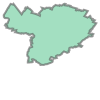

Amount of edges in cropped gdf: 20814


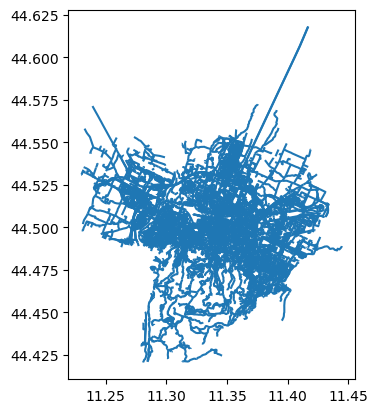

In [28]:
# Bologna: 43172 https://www.openstreetmap.org/relation/43172

relation = ox.geocoder.geocode_to_gdf("R43172", by_osmid=True).iloc[0,:]
display(pd.DataFrame(relation))
relation_geometry = relation['geometry']
display(relation_geometry)

rel_geometry_prep = shapely.prepared.prep(relation_geometry)
gdf_shp_cropped = gdf2.loc[gdf2.geometry.apply(lambda p: rel_geometry_prep.intersects(p) or rel_geometry_prep.contains(p))]

gdf_shp_cropped.plot();
print(f"Amount of edges in cropped gdf: {len(gdf_shp_cropped)}")

In [29]:
graph_gdf_nodes, graph_gdf_edges = ox.graph_to_gdfs(graph, fill_edge_geometry=False)

c:\Users\fillo\anaconda3\envs\ox\Lib\site-packages\osmnx\utils_graph.py:88: FutureWarning: You are adding a column named 'geometry' to a GeoDataFrame constructed without an active geometry column. Currently, this automatically sets the active geometry column to 'geometry' but in the future that will no longer happen. Instead, either provide geometry to the GeoDataFrame constructor (GeoDataFrame(... geometry=GeoSeries()) or use `set_geometry('geometry')` to explicitly set the active geometry column.
  gdf_edges["geometry"] = np.nan


In [30]:
print(f"% of available geometry data: {100 * len(graph_gdf_edges['geometry'].dropna()) / len(graph_gdf_edges):.2f}%")

% of available geometry data: 0.00%


Geometry data returned normally by osmnx is generated during the default graph simplification, by merging together nodes with continuous streets; still, various edges in the non-simplified graphs have the same OSM way id, so let's try simplifying those by merging ones with the same id.

In [31]:
graph_gdf_edges.columns

Index(['osmid', 'oneway', 'lanes', 'ref', 'name', 'highway', 'maxspeed',
       'reversed', 'length', 'bridge', 'access', 'junction', 'service',
       'tunnel', 'width', 'geometry'],
      dtype='object')

Osmnx way edges are doubled in cases where the way is not one-way, as seen next:

In [33]:
print("Sample way reversed edges:    ", len(graph_gdf_edges[(graph_gdf_edges['osmid'] == 5010592) & graph_gdf_edges['reversed']]))
print("Sample way non-reversed edges:", len(graph_gdf_edges[(graph_gdf_edges['osmid'] == 5010592) & ~graph_gdf_edges['reversed']]))
print("All reversed edges:    ", len(graph_gdf_edges[graph_gdf_edges['reversed']]))
print("All non-reversed edges:", len(graph_gdf_edges[~graph_gdf_edges['reversed']]))
print("All two-way reversed edges:    ", len(graph_gdf_edges[graph_gdf_edges['reversed'] & ~graph_gdf_edges['oneway']]))
print("All two-way non-reversed edges:", len(graph_gdf_edges[~graph_gdf_edges['reversed'] & ~graph_gdf_edges['oneway']]))

Sample way reversed edges:     11
Sample way non-reversed edges: 11
All reversed edges:     77999
All non-reversed edges: 107222
All two-way reversed edges:     77999
All two-way non-reversed edges: 77999


Thus, reversed edges can safely be discarded during simplification (and re-created after).

In [124]:
from route2vel.loading import compress_edges_dataframe

osmids = graph_gdf_edges.osmid.unique()
n_osmids = osmids[410:430]
gdf_n = graph_gdf_edges[graph_gdf_edges.osmid.isin(n_osmids)]

s_gdf_first_n = compress_edges_dataframe(gdf_n, graph_gdf_nodes)
s_gdf_first_n.head()

,oneway,lanes,ref,name,highway,maxspeed,bridge,access,junction,service,tunnel,width,length,u,v,nodes,geometry
osmid,,,,,,,,,,,,,,,,,
23189359,True,1,None,Via Fratelli Rosselli,residential,30,None,None,None,None,None,None,136.791,250763487,250763500,"[250763487, 3446465201, 2997999756, 250763500]","LINESTRING (11.33816 44.50382, 11.33814 44.503..."
23189364,True,1,None,Via del Porto,residential,30,None,None,None,None,None,None,382.058,250763510,250763506,"[250763510, 250763598, 250763540, 3241253092, ...","LINESTRING (11.34179 44.50072, 11.34093 44.500..."
23189373,True,None,None,Via Montebello,residential,30,None,None,None,None,None,None,126.438,250763533,400881769,"[250763533, 2984201636, 3241211135, 400881769]","LINESTRING (11.34226 44.50168, 11.34231 44.501..."
23275873,True,1,None,Via Avesella,residential,30,None,None,None,None,None,None,178.938,250763510,252168657,"[250763510, 1618154998, 1618154194, 1818368752...","LINESTRING (11.34179 44.50072, 11.34179 44.500..."
23296623,False,2,None,Via Don Giovanni Minzoni,tertiary,30,None,None,None,None,None,None,124.428,1629618102,250763500,"[1629618102, 2998004551, 250763500]","LINESTRING (11.33913 44.50232, 11.33776 44.502..."


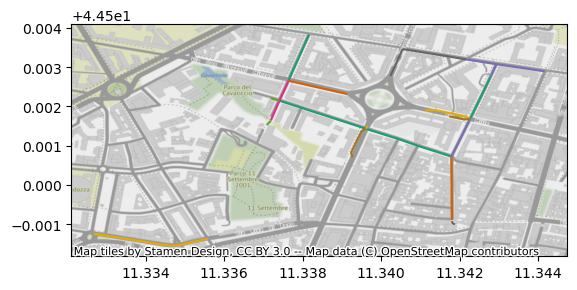

In [125]:
fig, ax = plt.subplots()
s_gdf_first_n.reset_index().plot('osmid', categorical=True, cmap='Dark2', ax=ax)
cx.add_basemap(crs = s_gdf_first_n.crs, ax=ax)
plt.show()

In [148]:
# Count amount of extra node id mismatches compared to edge length
# 0: all nodes in u have a match in v -> circle / loop
# 1: only 1 node in u and 1 node in v are mismatched -> normal street
# 2: more mismatches -> unconnected edges
edge_node_connection_mismatches = graph_gdf_edges[~graph_gdf_edges.reversed].reset_index().groupby('osmid').agg(**{
    'u': ('u', lambda x: x.tolist()),
    'v': ('v', lambda x: x.tolist()),
    'num': ('osmid', 'count'),
}).apply(lambda row: len(pd.Series(row['u'] + row['v']).unique()) - row['num'], axis=1)

print("Wrong edges:")
wrong_ids = edge_node_connection_mismatches[~edge_node_connection_mismatches.isin([0, 1])].index.values
pd.DataFrame(edge_node_connection_mismatches[wrong_ids])

Wrong edges:


,0
osmid,
101231813,2
133366766,-1
174578434,2
231284298,-1
302328448,-1
619450491,2
767111058,2
822525284,2
828892892,-1


In [173]:
print("Experiment with an edge with disconnected segments")
compress_edges_dataframe(graph_gdf_edges[graph_gdf_edges.osmid == 101231813], return_geometry=False).nodes[101231813]

Experiment with an edge with disconnected segments


[2146238572,
 1760542561,
 253665095,
 253267940,
 253267828,
 1168633586,
 253267829,
 253267831,
 253267832,
 1760542487,
 253267833,
 253267834,
 1459019509]

In [178]:
# print("Experiment with an edge with -1 mismatch (inner multiple loops)")
# compress_edges_dataframe(graph_gdf_edges[graph_gdf_edges.osmid == 302328448], return_geometry=False).nodes[302328448]

In [193]:
import pickle 
from math import ceil
import os

step = 5000
workdir = "bologna_test"
dirpath = os.path.join('../../resources/pickle/', workdir)
# Directly drop the hard to handle shapes as we just need a simple comparision
drop_complex_shapes=True

if not os.path.exists(dirpath):
    os.makedirs(dirpath)

for file in os.listdir(dirpath):
    os.remove(os.path.join(dirpath, file))

print(f"=======\nFiles to write: {ceil(len(osmids) / step)}\n=======")
for i, idx in enumerate(range(0, len(osmids), step)):
    print(f"Doing {i}, {idx}-{min(idx+step, len(osmids))}, from {osmids[idx]}")
    gdf_i = graph_gdf_edges[graph_gdf_edges.osmid.isin(osmids[idx:min(idx+step, len(osmids))])]
    s_gdf_i = compress_edges_dataframe(gdf_i, graph_gdf_nodes, drop_complex_shapes=drop_complex_shapes)
    fn = f'tmp_gdf_{i:02d}_{idx}.pickle'
    with open(f'{dirpath}/{fn}', 'wb') as f:
        pickle.dump(s_gdf_i, f)
    print(f"Saved {fn}")



Files to write: 5
Doing 0, 0-5000, from 107202479
Saved tmp_gdf_00_0.pickle
Doing 1, 5000-10000, from 148704600
Saved tmp_gdf_01_5000.pickle
Doing 2, 10000-15000, from 199908799
Saved tmp_gdf_02_10000.pickle
Doing 3, 15000-20000, from 552591541
Saved tmp_gdf_03_15000.pickle
Doing 4, 20000-20305, from 1170993290
Saved tmp_gdf_04_20000.pickle


In [194]:
loaded_gdfs = []

for file in os.listdir(dirpath):
    with open(f'{dirpath}/{file}', 'rb') as f:
        loaded_gdfs.append(pickle.load(f))

merged_graph_edges_gdf = pd.concat(loaded_gdfs)

print(f"Merged gdf length: {len(merged_graph_edges_gdf)}, original osmids: {len(osmids)}, loss: {len(osmids) - len(merged_graph_edges_gdf)}")

Merged gdf length: 20295, original osmids: 20305, loss: 10


In [195]:
def pos(node: dict):
    return (node['x'], node['y'])

ovp_edge_points = merged_graph_edges_gdf.reset_index()[['u', 'v', 'osmid']] \
    .assign(
        u_pos = lambda d: d['u'].apply(lambda x: pos(graph.nodes[x])),
        v_pos = lambda d: d['v'].apply(lambda x: pos(graph.nodes[x])),
    ).set_index('osmid')

Compare point coordinates between shapefile and ovp

In [196]:
shp_edge_points = gdf_shp_cropped.assign(
    u_pos = lambda d: d['geometry'].apply(lambda x: x.coords[0]),
    v_pos = lambda d: d['geometry'].apply(lambda x: x.coords[-1]),
)[['u_pos', 'v_pos']]

display(shp_edge_points.head())
display(ovp_edge_points.head())

,u_pos,v_pos
osmid,,
5010592,"(11.3542902, 44.5004229)","(11.3545777, 44.4994125)"
8116113,"(11.3437988, 44.4990705)","(11.3431127, 44.4966968)"
10048700,"(11.3365532, 44.4729475)","(11.3365096, 44.4746224)"
11480268,"(11.3410144, 44.4951565)","(11.3409916, 44.4950817)"
11480374,"(11.3464651, 44.4942399)","(11.3509776, 44.4924769)"


,u,v,u_pos,v_pos
osmid,,,,
5010592,3362501093,250718677,"(11.3542902, 44.5004229)","(11.3545777, 44.4994125)"
8116113,8992868196,1628755043,"(11.3437988, 44.4990705)","(11.3431127, 44.4966968)"
10048700,347468528,336773774,"(11.3365532, 44.4729475)","(11.3365096, 44.4746224)"
11480268,252169103,3309418390,"(11.3410144, 44.4951565)","(11.3409916, 44.4950817)"
11480374,82550591,251896760,"(11.3464651, 44.4942399)","(11.3509776, 44.4924769)"


In [197]:
print(f"There are {len(shp_edge_points)} edges in SHP and {len(ovp_edge_points)} in base OSM ({len(shp_edge_points) - len(ovp_edge_points)} more)")

There are 20814 edges in SHP and 20295 in base OSM (519 more)


In [198]:
joined_points = shp_edge_points.join(
    ovp_edge_points, 
    how='inner',
    lsuffix='_ovp', rsuffix='_shp',
)

joined_points

,u_pos_ovp,v_pos_ovp,u,v,u_pos_shp,v_pos_shp
osmid,,,,,,
5010592,"(11.3542902, 44.5004229)","(11.3545777, 44.4994125)",3362501093,250718677,"(11.3542902, 44.5004229)","(11.3545777, 44.4994125)"
8116113,"(11.3437988, 44.4990705)","(11.3431127, 44.4966968)",8992868196,1628755043,"(11.3437988, 44.4990705)","(11.3431127, 44.4966968)"
10048700,"(11.3365532, 44.4729475)","(11.3365096, 44.4746224)",347468528,336773774,"(11.3365532, 44.4729475)","(11.3365096, 44.4746224)"
11480268,"(11.3410144, 44.4951565)","(11.3409916, 44.4950817)",252169103,3309418390,"(11.3410144, 44.4951565)","(11.3409916, 44.4950817)"
11480374,"(11.3464651, 44.4942399)","(11.3509776, 44.4924769)",82550591,251896760,"(11.3464651, 44.4942399)","(11.3509776, 44.4924769)"
...,...,...,...,...,...,...
1176635072,"(11.3652573, 44.4869413)","(11.3652655, 44.4869503)",10931971636,10931971641,"(11.3652573, 44.4869413)","(11.3652655, 44.4869503)"
1176635073,"(11.3621033, 44.4868391)","(11.362652, 44.4875984)",10931971449,10931971644,"(11.3621033, 44.4868391)","(11.362652, 44.4875984)"
1176635074,"(11.3652482, 44.4869317)","(11.3652243, 44.4868958)",10931971634,10931971558,"(11.3652482, 44.4869317)","(11.3652243, 44.4868958)"


In [199]:
# flip segments with inverted u/v (by checking distances)
u_pos_shp = np.array(joined_points['u_pos_shp'].to_list()).transpose()
v_pos_shp = np.array(joined_points['v_pos_shp'].to_list()).transpose()
u_pos_ovp = np.array(joined_points['u_pos_ovp'].to_list()).transpose()
v_pos_ovp = np.array(joined_points['v_pos_ovp'].to_list()).transpose()

u_shp_u_ovp_dist = ox.distance.great_circle_vec(u_pos_shp[0], u_pos_shp[1], u_pos_ovp[0], u_pos_ovp[1])
u_shp_v_ovp_dist = ox.distance.great_circle_vec(u_pos_shp[0], u_pos_shp[1], v_pos_ovp[0], v_pos_ovp[1])
v_shp_v_ovp_dist = ox.distance.great_circle_vec(v_pos_shp[0], v_pos_shp[1], v_pos_ovp[0], v_pos_ovp[1])
v_shp_u_ovp_dist = ox.distance.great_circle_vec(v_pos_shp[0], v_pos_shp[1], u_pos_ovp[0], u_pos_ovp[1])

edges_flip = (u_shp_u_ovp_dist > u_shp_v_ovp_dist) & (v_shp_v_ovp_dist > v_shp_u_ovp_dist)

joined_points['flip'] = edges_flip
joined_points['u_dist'] = np.where(edges_flip, u_shp_u_ovp_dist, u_shp_v_ovp_dist)
joined_points['v_dist'] = np.where(edges_flip, v_shp_v_ovp_dist, v_shp_u_ovp_dist)
joined_points[['u_dist', 'v_dist']].describe()

,u_dist,v_dist
count,20201.000000,20201.000000
mean,109.286195,108.906441
std,176.171037,173.121910
min,0.000000,0.000000
25%,20.105418,20.105418
50%,53.382361,53.234206
75%,127.678456,127.619371
max,3774.558084,3774.558084


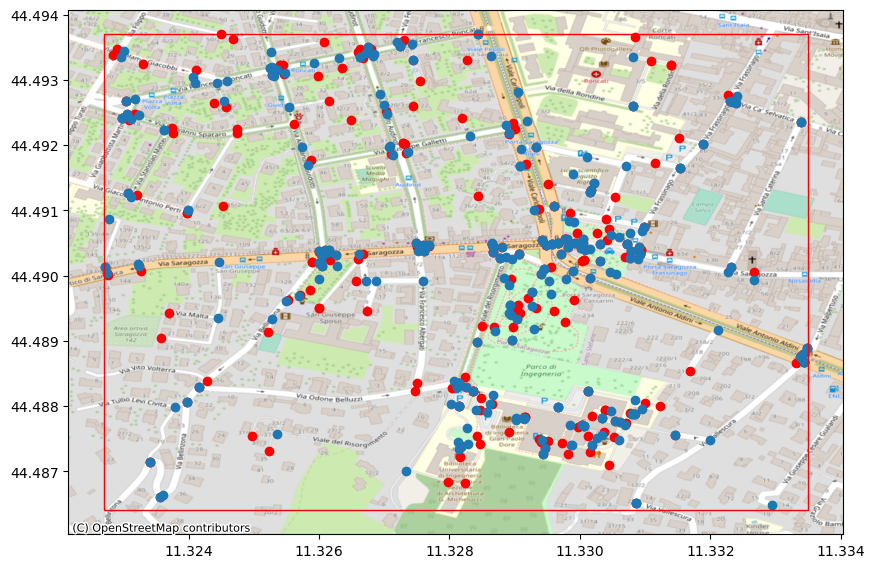

In [200]:
display_bounded_shapes([
   (gpd.GeoDataFrame({
        'u_shp': [shapely.Point(v) for v in joined_points['v_pos_shp']],
    }, geometry='u_shp'), {'color': 'red'}),
    (gpd.GeoDataFrame({
        'u_ovp': [shapely.Point(u) for u in joined_points['u_pos_ovp']],
    }, geometry='u_ovp'), {}),
], (11.3227, 44.4864), (11.3335, 44.4937), latLong=False);

Is there any edge that has missing geometry in original that has geometry in the shapefile?

In [258]:
joined = merged_graph_edges_gdf.reset_index()\
    .set_index('osmid') \
    .join(
        gdf_shp_cropped \
            [['geometry', 'name']] \
            , 
        lsuffix='_og', rsuffix='_shp',
    )
joined

,oneway,lanes,ref,name_og,highway,maxspeed,bridge,access,junction,service,tunnel,width,length,u,v,nodes,geometry_og,geometry_shp,name_shp
osmid,,,,,,,,,,,,,,,,,,,
5010592,False,None,None,Via Filippo Re,service,None,None,None,None,None,None,None,279.807,3362501093,250718677,"[3362501093, 5552774639, 3362498892, 336249889...","LINESTRING (11.35429 44.50042, 11.35445 44.500...","LINESTRING (11.35429 44.50042, 11.35445 44.500...",Via Filippo Re
8116113,False,2,None,Via dell'Indipendenza,secondary,30,None,designated,None,None,None,None,269.496,8992868196,1628755043,"[8992868196, 9051116141, 3241202567, 361558774...","LINESTRING (11.34380 44.49907, 11.34379 44.499...","LINESTRING (11.34380 44.49907, 11.34379 44.499...",Via dell'Indipendenza
10048700,False,None,None,Via San Mamolo,residential,None,None,None,None,None,None,None,361.188,347468528,336773774,"[347468528, 3342568953, 347468530, 347468531, ...","LINESTRING (11.33655 44.47295, 11.33665 44.473...","LINESTRING (11.33655 44.47295, 11.33665 44.473...",Via San Mamolo
11480268,True,None,None,Via Giacomo Venezian,residential,30,None,None,None,None,None,None,8.511,252169103,3309418390,"[252169103, 7528426027, 3309418390]","LINESTRING (11.34101 44.49516, 11.34100 44.495...","LINESTRING (11.34101 44.49516, 11.34100 44.495...",Via Giacomo Venezian
11480374,True,1,None,Strada Maggiore,secondary,30,None,None,None,None,None,None,409.059,82550591,251896760,"[82550591, 3026794171, 8477370231, 102265546, ...","LINESTRING (11.34647 44.49424, 11.34656 44.494...","LINESTRING (11.34647 44.49424, 11.34656 44.494...",Strada Maggiore
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1177854844,False,None,None,None,footway,None,None,None,None,None,None,None,119.969,10941901806,10941901868,"[10941901806, 10941901863, 10941901864, 109419...","LINESTRING (11.36256 44.48459, 11.36257 44.484...",None,NaN
1177854846,False,None,None,None,footway,None,None,None,None,None,None,None,10.559,10941901853,10941901886,"[10941901853, 10941901899, 10941901886]","LINESTRING (11.36200 44.48385, 11.36197 44.483...",None,NaN
1177854854,False,None,None,None,service,None,None,private,None,driveway,None,None,51.751,10941901958,10941901609,"[10941901958, 10941901959, 10941901960, 109419...","LINESTRING (11.36203 44.48283, 11.36192 44.482...",None,NaN


In [214]:
left_null = joined[joined['geometry_shp'].isnull()] #geometry always present in SHP and not OVP
print(f"Edges in OSM with no equivalent in SHP: {len(left_null)}, {len(left_null) * 100 / len(graph_gdf_edges):.2f}%")

Edges in OSM with no equivalent in SHP: 94, 0.05%


In [217]:
right_null_num = count_unmatched_values(gdf_shp_cropped.reset_index().set_index('osmid'), merged_graph_edges_gdf.reset_index().set_index('osmid'))
print(f"Edges in SHP with no equivalent in OSM: {right_null_num}, {right_null_num * 100 / len(gdf_shp_cropped):.2f}%")

Edges in SHP with no equivalent in OSM: 613, 2.95%


In [218]:
name_mismatch = joined[~((joined['name_og'].apply(lambda x: str(x).strip().lower()) == joined['name_shp'].apply(lambda x: str(x).strip().lower())) | (joined['name_og'].isnull() & joined['name_og'].isnull()))]
print(f"Edges with name mismatch: {len(name_mismatch)}, {len(name_mismatch) * 100 / len(joined):.2f}%")
pd.DataFrame(name_mismatch[['name_og', 'name_shp']].value_counts(dropna=False))

Edges with name mismatch: 16, 0.08%


,,count
name_og,name_shp,
Corridoio Ala Lunga,NaN,2
Percorso Riservato,NaN,2
Raccordo Ala Lunga - Corpo D,NaN,2
Galleria Vialarga,NaN,1
Percorso Ascensori Centrali,NaN,1
Percorso Corpo D,NaN,1
Percorso Edificio L,NaN,1
Percorso Info-Point,NaN,1
Percorso LUM,NaN,1


In [223]:
joined['name'] = joined['name_og']

Sample comparision:
Edge name: Via del Lazzaretto, id: 149916588, length: 26.3m (29.9m from geometry)
SHP geometry: n° points 6, avg point distance 4.985m, avg point density 0.201


,coords,dist_to_next
0,"(11.3180442, 44.5129253)",11.033471
1,"(11.3179315, 44.5129835)",4.097244
2,"(11.3179023, 44.5130139)",2.849058
3,"(11.3178901, 44.513038)",3.214924
4,"(11.3178825, 44.5130664)",5.130614
5,"(11.3178759, 44.5131123)",0.000000


Geometry gfx


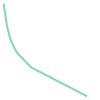

In [240]:
# average distance between adjacent line points
def point_distance(line: shapely.LineString):
    return coord_shape_length_meters(line) / len(line.coords)

# returns points per meter
def point_density(line: shapely.LineString):
    return len(line.coords) / coord_shape_length_meters(line)

print("Sample comparision:")
idx = math.floor(len(joined) * 0.33)
edge = joined.sort_values(by='length', ascending=True).iloc[idx, :]
geom: shapely.LineString = edge['geometry_shp']
print(f"Edge name: {edge['name']}, id: {joined.index.values[idx]}, length: {edge['length']:.1f}m ({coord_shape_length_meters(geom):.1f}m from geometry)")
print(f"SHP geometry: n° points {len(geom.coords)}, avg point distance {point_distance(geom):.3f}m, avg point density {point_density(geom):.3f}")

display(pd.DataFrame({
    'coords': list(geom.coords),
    'dist_to_next': [coord_distance_meters(cur, next) for cur, next in zip(geom.coords[:-1], geom.coords[1:])] + [0],
}))

print("Geometry gfx")
display(edge['geometry_shp'])

Length calculated from ox data doesn't seem to match with length calculated from geometry: let's check this more generally.

In [241]:
joined['length_shp'] = [coord_shape_length_meters(geom) if geom else None for geom in joined['geometry_shp']]

In [244]:
with pd.option_context('display.float_format', lambda x: f'{x:,.3f}'):
    display(joined[joined['geometry_shp'].notnull()][['length', 'length_shp']].assign(ratio = lambda x: x.length_shp / x.length).describe())

,length,length_shp,ratio
count,"20,201.000","20,201.000","20,201.000"
mean,105.505,128.252,1.234
std,163.921,205.131,1.976
min,0.336,0.414,0.506
25%,18.206,21.830,1.070
50%,52.477,62.387,1.201
75%,126.531,150.991,1.332
max,"3,068.916","3,969.886",244.014


Computed shapefile length data seems to be not properly matched to the OSM length. Will need more thorough consistency checks, if needed.

Checking detail in geometry data between Overpass and SHP:

In [281]:
geom_comparision = joined[joined.geometry_shp.notnull()].assign(
    points_num_shp = lambda d: d.geometry_shp.apply(lambda geom: len(geom.coords)),
    points_num_og = lambda d: d.geometry_og.apply(lambda geom: len(geom.coords)),
    points_avgdist_shp = lambda d: d.geometry_shp.apply(point_distance),
    points_avgdist_og = lambda d: d.geometry_og.apply(point_distance),
)[['points_num_shp', 'points_num_og', 'points_avgdist_shp', 'points_avgdist_og']]
display(geom_comparision)
geom_comparision.describe()

,points_num_shp,points_num_og,points_avgdist_shp,points_avgdist_og
osmid,,,,
5010592,12,12,25.339533,25.339533
8116113,16,16,16.862729,16.862729
10048700,30,30,14.594753,14.594753
11480268,3,3,2.846681,2.846681
11480374,19,19,28.325406,28.325406
...,...,...,...,...
1176635070,4,4,9.680698,9.680698
1176635071,3,3,1.057240,1.057240
1176635072,2,2,0.669701,0.669701


,points_num_shp,points_num_og,points_avgdist_shp,points_avgdist_og
count,20201.000000,20201.000000,20201.000000,20201.000000
mean,6.327410,6.290283,19.821922,19.783974
std,7.723856,7.567046,20.694677,20.664613
min,2.000000,2.000000,0.206878,0.206878
25%,3.000000,3.000000,6.406484,6.398280
50%,4.000000,4.000000,13.676688,13.646991
75%,7.000000,7.000000,26.119391,26.051067
max,262.000000,262.000000,380.057672,380.057672


,points_num_shp,points_num_og,points_avgdist_shp,points_avgdist_og
osmid,,,,
17064129,35,19,15.521888,18.361428
23189090,12,13,37.757352,34.852946
23189134,13,15,42.086636,36.475098
23189164,3,5,61.949457,37.077814
23189165,7,8,30.319575,26.603378
...,...,...,...,...
1172613652,10,11,92.118458,101.174075
1175557014,3,2,15.432192,8.240001
1176635039,10,15,22.373489,24.467048


Comparing 17064129
Shapefile


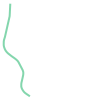

Overpass


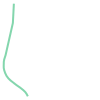

In [282]:
diff = geom_comparision[geom_comparision.points_num_shp != geom_comparision.points_num_og]
display(diff)
compare_idx = diff.index.values[0]
print("Comparing", compare_idx)
print("Shapefile")
display(joined.loc[compare_idx, 'geometry_shp'])
print("Overpass")
display(joined.loc[compare_idx, 'geometry_og'])

In [ ]:
# show geodataframe plot of non-matching ways

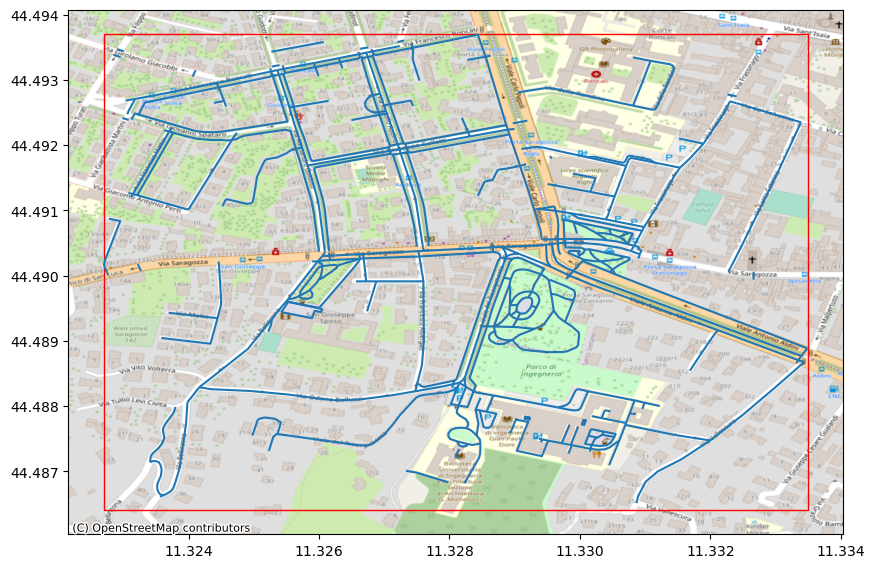

In [250]:
display_bounded_shapes(gdf_shp_cropped, (11.3227, 44.4864), (11.3335, 44.4937));

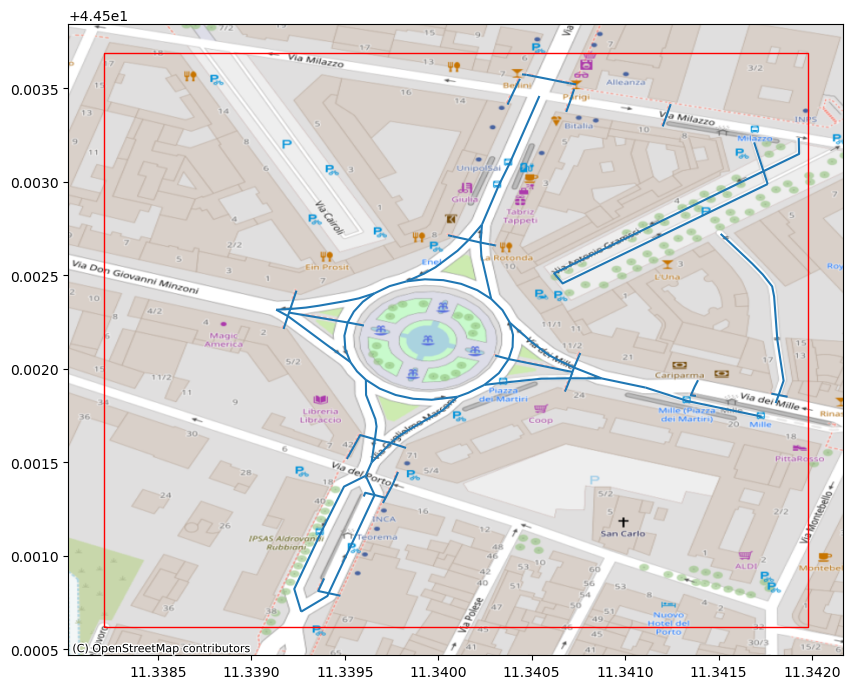

In [254]:
[gdf_roundabout] = display_bounded_shapes(gdf_shp_cropped, (44.50369, 11.33821), (44.50062, 11.34198), latLong=True)

Maybe faster alternative to load shapefile: GeoPandas

In [ ]:
# shapefile = gpd.read_file("shapefile.shp")
# print(shapefile)